##### Sami Ramzi Chibane © 

##### Ce bloc-notes utilise pandana (v0.6.1) pour télécharger les données du réseau routier et des points d'intérêt à partir d'OpenStreetMap, puis calculer l'accessibilité du réseau aux points d'intérêt.

In [1]:
import pandana, matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline

##### Remarque/ il est possible de générer les cordoonées de la bbox qui vous intéresse sur ce site  :  https://boundingbox.klokantech.com/
##### Ensuite, il faut insérer les cordonnées dans l'ordre suivant : "Sud, Ouest, Nord, Est" au lieu de l'ordre proposé par le site boundingbox : "Ouest, Sud, Est, Nord"

#### L'exemple des "restaurants" à Nantes en France

In [2]:
bbox = [47.118292,-1.694756,47.292525,-1.410485] #lat-long bounding box pour Grenoble
amenity = 'restaurant' 
distance = 1500 #distance maximale en mètres

In [3]:
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
9967912512,restaurant,NaN,47.156875,-1.523487
9986086458,restaurant,Tel Père Tel Fils,47.149300,-1.467946
10003999699,restaurant,La Mie Bio,47.226515,-1.638615
10016123117,restaurant,Bistrot Élémentaire,47.220732,-1.535481
10055855864,restaurant,L'Ecuelle,47.174159,-1.624639


In [4]:
# Interrogons l'API OSM pour le réseau routier dans le cadre de délimitation spécifiée
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])

# Affichons le nombre de nœuds du réseau obtenu pour cette bbox 
len(network.node_ids)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:147: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will b

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](47.11829200,-1.69475600,47.29252500,-1.41048500);>;);out;'}"
Downloaded 46,811.8KB from www.overpass-api.de in 11.05 seconds


C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnet\load.py:171: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ' {:,.2f} seconds'.format(len(geometry), time.time()-start_time))


Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 13.16 seconds
Returning OSM data with 297,045 nodes and 52,416 ways...
Edge node pairs completed. Took 30.68 seconds
Returning processed graph with 64,916 nodes and 90,926 edges...
Completed OSM data download and Pandana node and edge table creation in 50.75 seconds


64916

In [5]:
# Identifions les nœuds qui sont connectés à moins d'un certain seuil d'autres nœuds à une distance donnée
# Ne rien faire avec cela pour l'instant, mais voir l'exemple complet dans un autre carnet pour aller plus loin
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

In [6]:
# Précalculons les requêtes de plage (les nœuds accessibles à cette distance maximale)
network.precompute(distance + 1)

In [7]:
# Initialisez ensuite le moteur de points d'intérêt C++ sous-jacent
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [8]:
# Initialisez une catégorie pour cet équipement avec les emplacements spécifiés par les colonnes longitude et latitude
network.set_pois(category='my_amenity', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [9]:
# Recherchez les n commodités les plus proches de chaque nœud du réseau
access = network.nearest_pois(distance=distance, category='my_amenity', num_pois=7)

# chaque cellule dataframe représente la distance du réseau entre le nœud et chacun des n POI
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
25959075,1336.329956,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.0
25959239,1283.004028,1436.535034,1497.774048,1500.0,1500.0,1500.0,1500.0
25959484,1167.443970,1320.974976,1382.213989,1500.0,1500.0,1500.0,1500.0
25959729,1500.000000,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.0
25959822,1500.000000,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.0


In [10]:
# Arguments des paramètres à passer pour la figure matplotlib
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(40, 40 * bbox_aspect_ratio)}

# Arguments des paramètres à passer pour les nuages de points
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

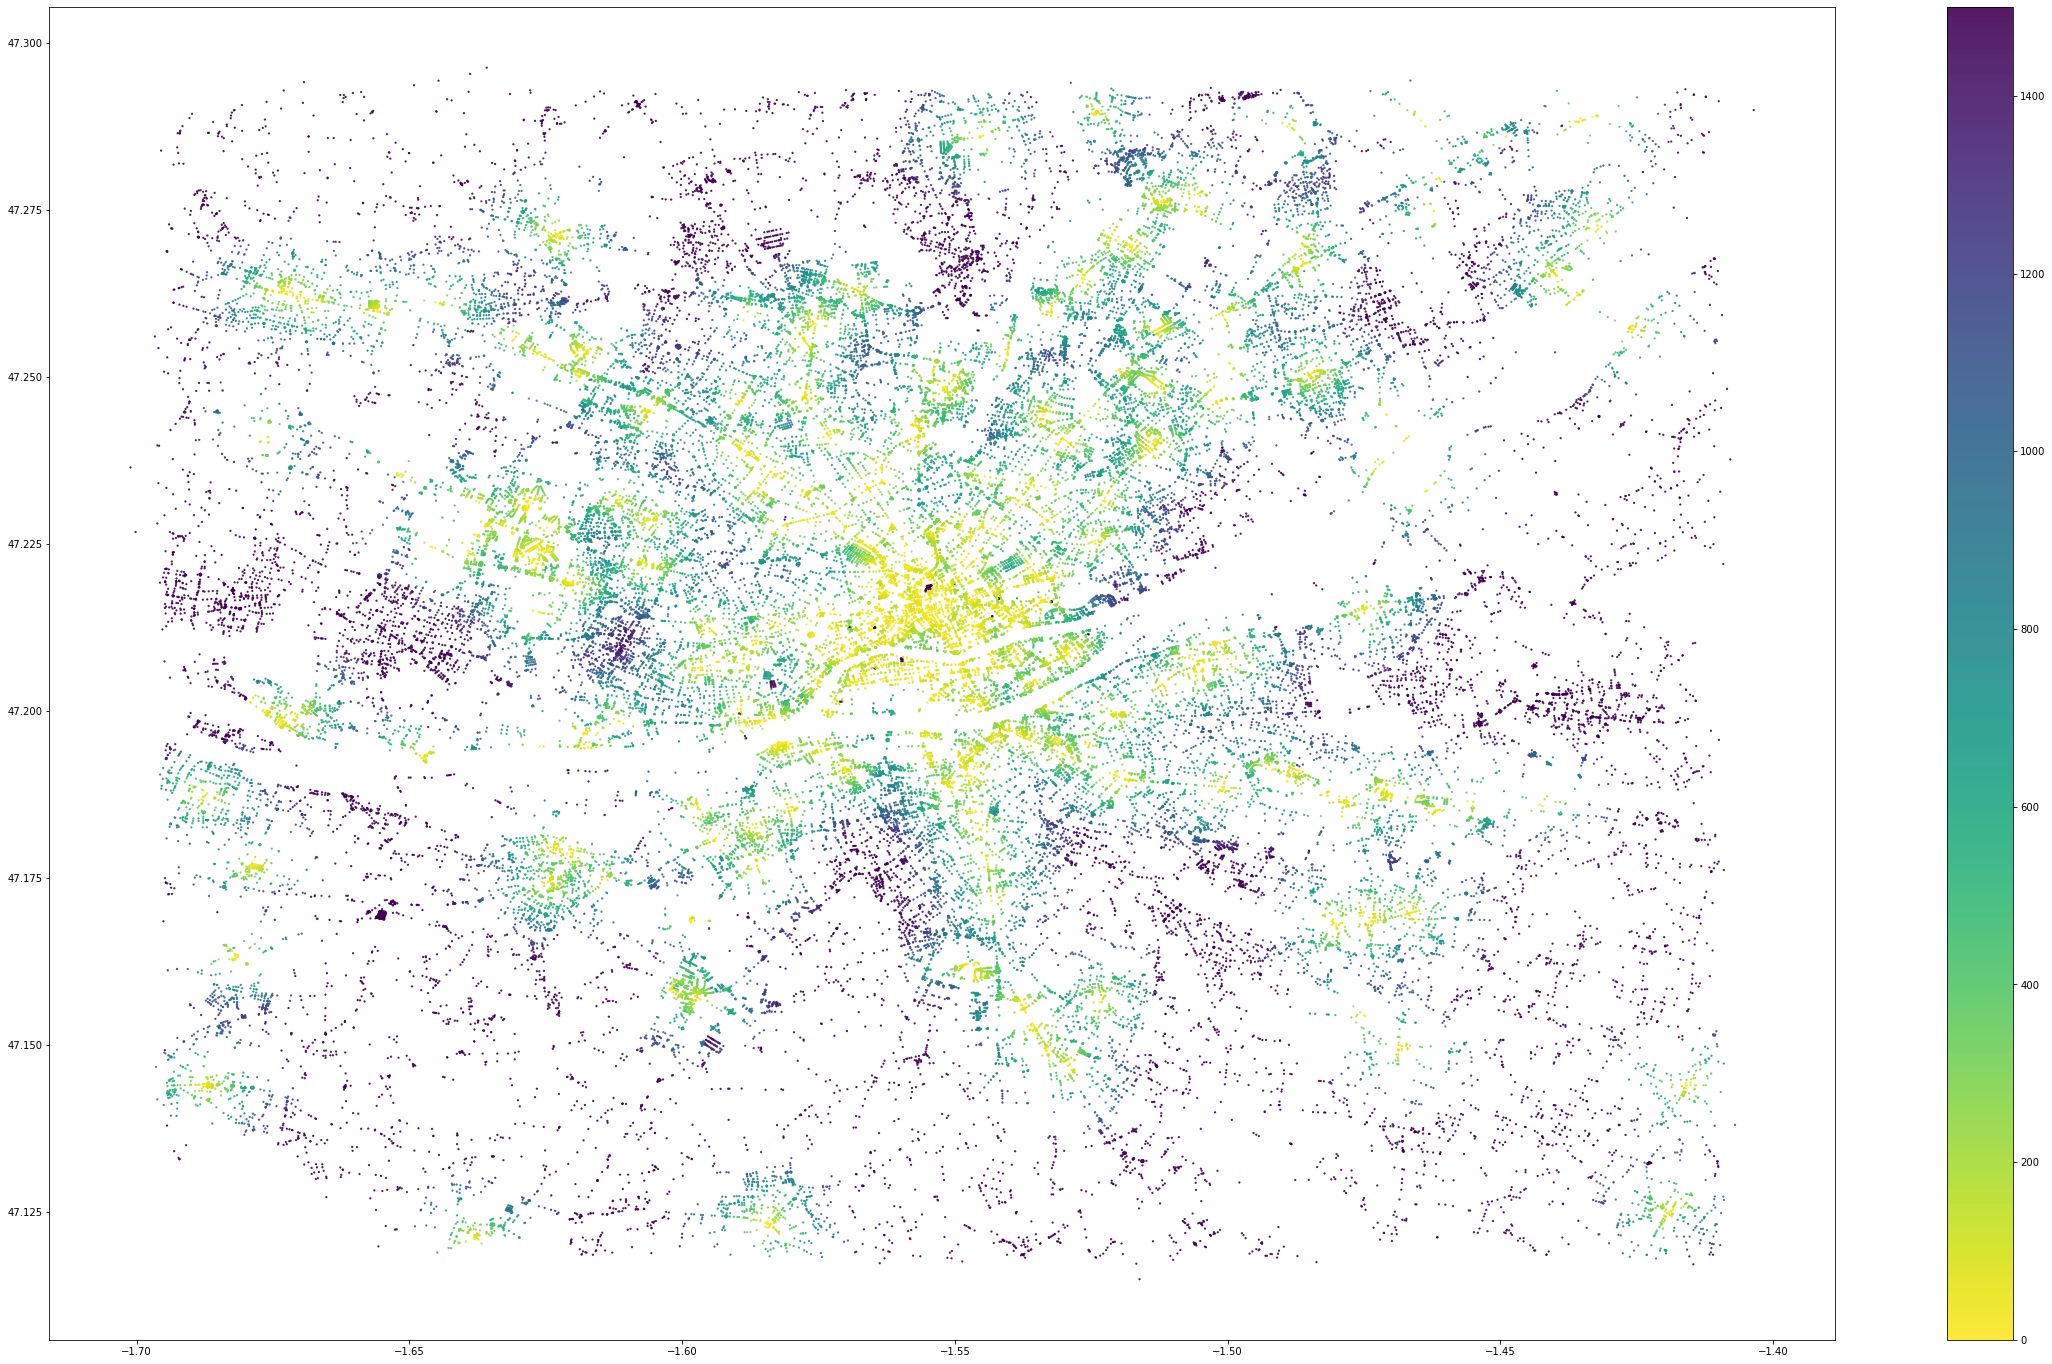

ValueError: not enough values to unpack (expected 3, got 2)

In [11]:
# Tracez la distance jusqu'à la nième aménité la plus proche
n = 1
bmap, fig, ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_axis_bgcolor('k')
fig.savefig('images/accessibility-cafe-east-bay.png', dpi=200, bbox_inches='tight')
plt.show()

##### Requêtes d'agrégation de réseau

In [12]:
# Obtenez d'abord le node_id le plus proche pour chaque point d'intérêt, en fonction de sa lat-lon
pois['node_ids'] = network.get_node_ids(pois['lon'], pois['lat'])

In [13]:
network.set(pois['node_ids'], variable=pois['capacity'], name='capacity')

Removed 775 rows because they contain missing values


In [14]:
capacity_sum = network.aggregate(distance=distance, type='sum', decay='linear', name='capacity')

In [15]:
# les tracés d'agrégation de réseau sont les mêmes que les tracés de dispersion réguliers, mais sans palette de couleurs inversée
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

In [16]:
cbar_kwargs = {}

In [17]:
# arguments des paramètres à transmettre au fond de carte
bmap_kwargs = {}

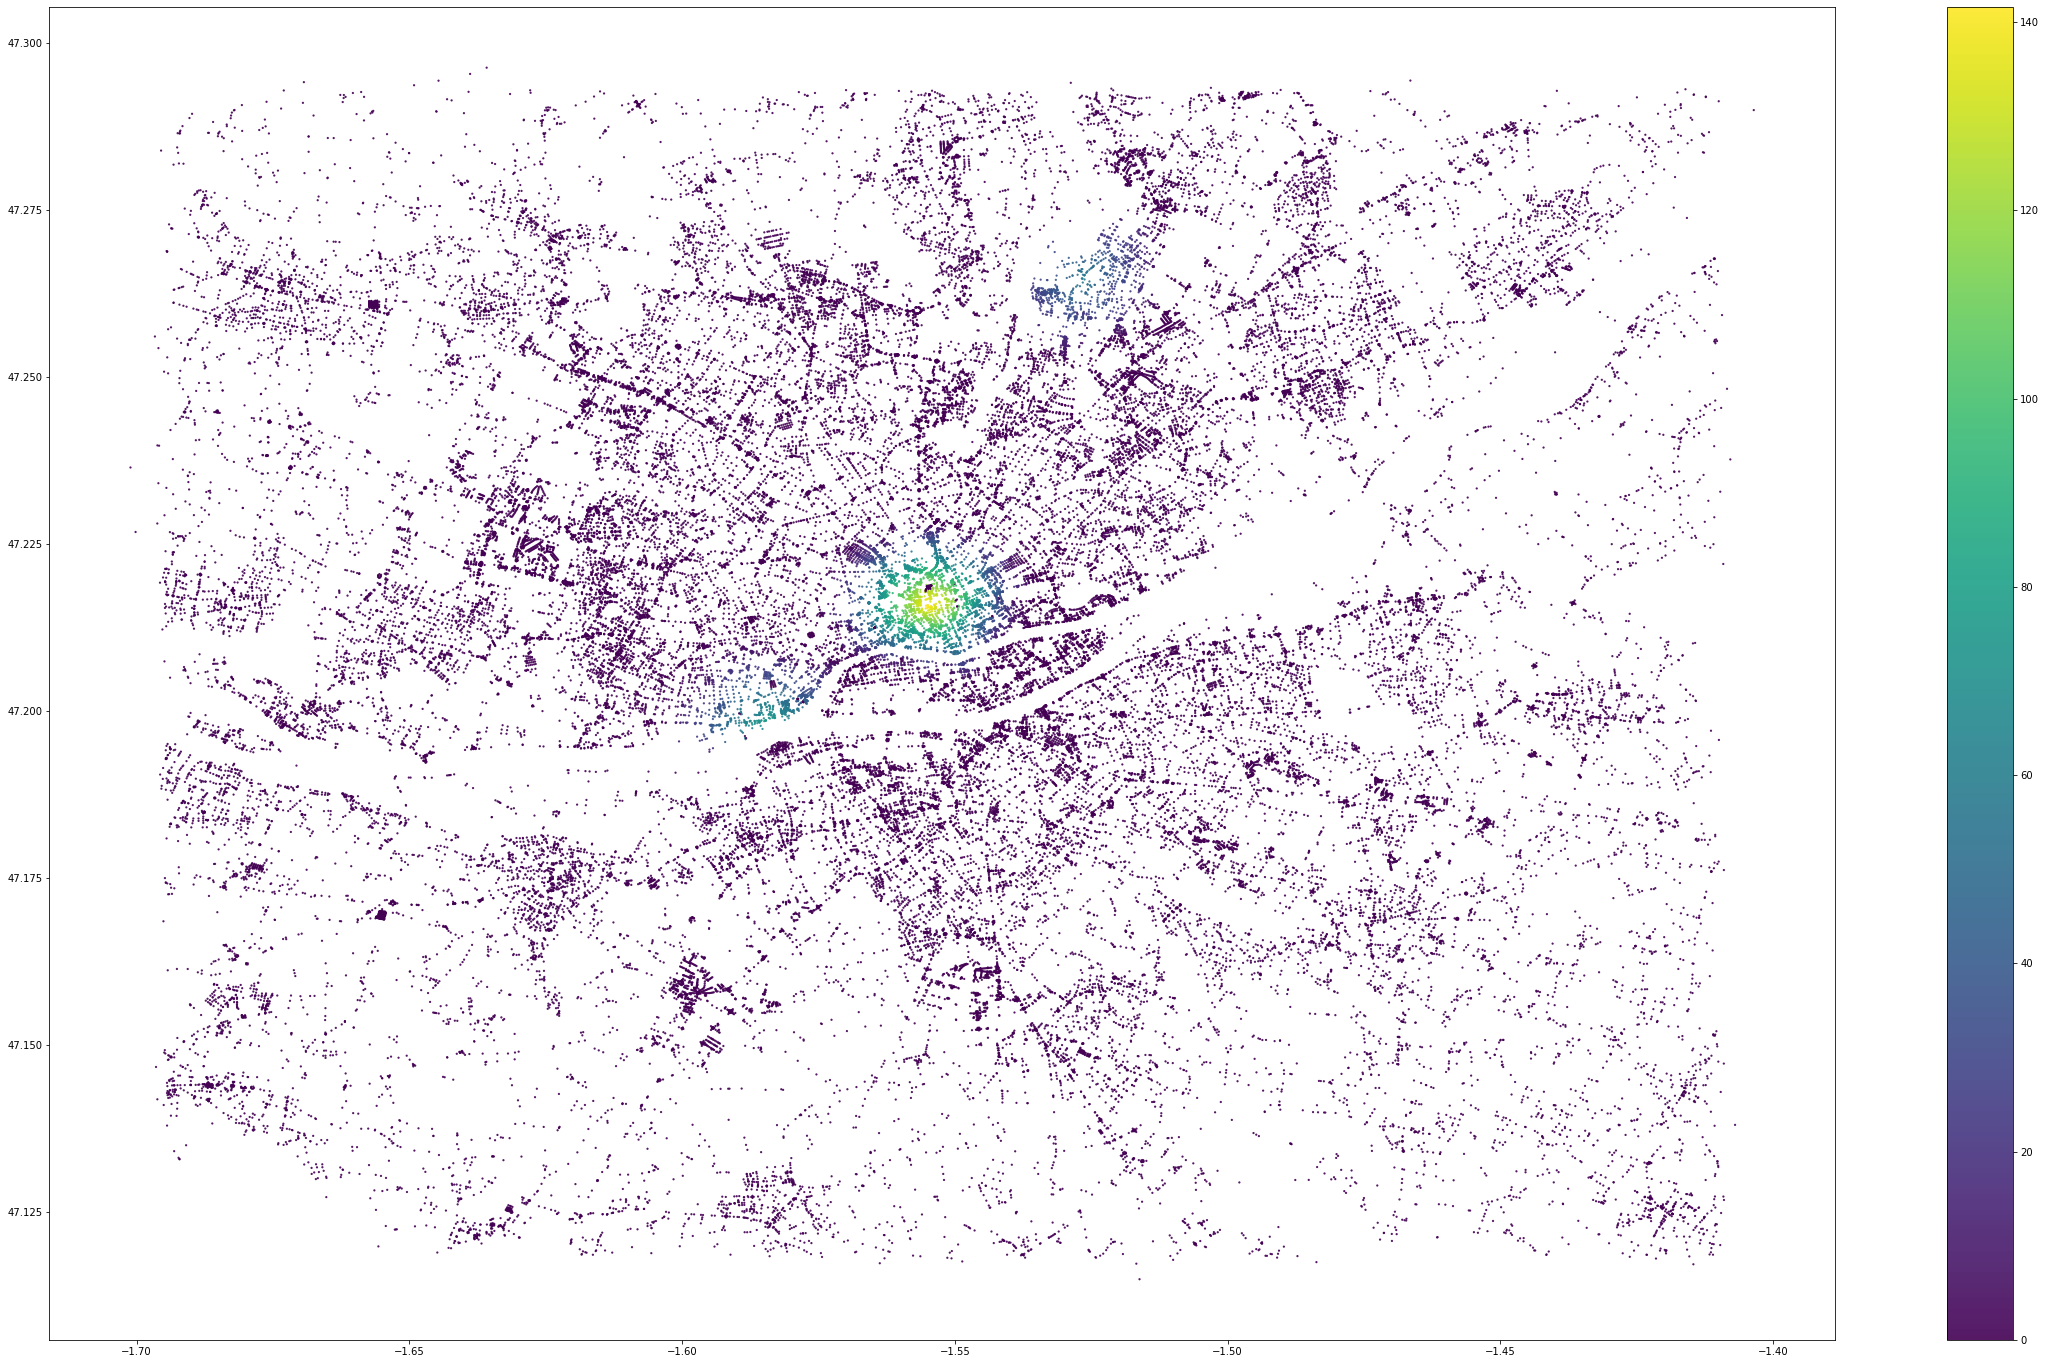

ValueError: not enough values to unpack (expected 3, got 2)

In [18]:
bmap, fig, ax = network.plot(capacity_sum, bbox=bbox, plot_type='scatter', plot_kwargs=agg_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_axis_bgcolor(bgcolor)